# Coding Assignment for Quiz "FL Algorithms" 

In order to answer the quiz questions for the MyCourses Quiz "FL Algorithms" you have to complete the coding tasks that are indicated below with 

`### STUDENT TASK`

## FedSGD

The code snippet implements the FedSGD algorithms from the lecture notes using a fixed number of iterations and constant learning rate (over iterations and nodes). 

In [1]:
# input: 
# - graph: networkx.Graph() whose nodes have attributes 
#         -- "X": feature matrix X^{(i)} with feature vectors in its colunms 
#         -- "y": label vector y^{(i)} with labels of data points in local dataset
#        .edges() are undirected and assumed to have unit weight (A_{i,j} = 1 for all edges)
# - lrate: learningrate used for the gradientsteps 
# - regparam: regularization parameter that scaled the GTV term 
# - maxiter: maximum number of gradient steps. 
#output: 
#  - graph node attribute "w" which holds the weights w^{(i)} 
#


def FedSGD(Gin,lrate=0.01,regparam=0,maxiter=100):
# init model parmas (weights of linear maps) to zero 

    for node_i in Gin.nodes(data=False): 
        # determine number of features used to characterize data points 
        # this nr. of features is equal to the length of the weight vector
        nrfeatures = Gin.nodes[node_i]["X"].shape[1]
        Gin.nodes[node_i]["w"] = np.zeros((nrfeatures,1))

    for iter_GD in range(maxiter):

    # the following "for loop" computes the local gradient at each node 
        for node_i in Gin.nodes(data=False):
            tmp_y = Gin.nodes[node_i]["y"].reshape(-1,1)
            tmp_X = Gin.nodes[node_i]["X"]
            localsamplesize = tmp_X.shape[0]
            currw = Gin.nodes[node_i]["w"]
            tmp_vec = np.zeros(currw.shape)
            for node_j in Gin[node_i]: 
                tmp_vec += (currw - Gin.nodes[node_j]["w"])
        
            update = (1/localsamplesize)*tmp_X.T.dot(tmp_y-tmp_X.dot(currw))-regparam*tmp_vec  
            # we need to store the updated weights in a dummy attribute 
            # as we need to use current weights for the updates of other nodes 
            Gin.nodes[node_i]["w_new"] = Gin.nodes[node_i]["w"]+2*lrate*update
        for node_i in Gin.nodes(data=False): 
             Gin.nodes[node_i]["w"] =  Gin.nodes[node_i]["w_new"]

In [2]:
import random
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import networkx as nx
import os



# this function reads in a networkx Graph gin whose nodes are expected to 
# have attribute "coord" holding latitude and longitude of FMI station 

def AddEgdesFMI(graphin,dmax=2): 
    dmax=2
     # create a numpy array with i-th row holding the lat/lon coordinates 
    # of i-th FMI station 

    X_coords = np.zeros((len(graphin.nodes),2))

    # iterate over all nodes in the FMI graph 

    for iter_node in range(len(graphin.nodes)): 
        X_coords[iter_node,:] = graphin.nodes[iter_node]['coord']

    from sklearn.neighbors import kneighbors_graph

    # create a matrix whose rows and cols represent FMI stations 
    # the entry A_{i,j} is non-zero if FMI station i is among dmax nearest 
    # neighbors of station j 

    A = kneighbors_graph(X_coords, dmax,mode='connectivity', include_self=False)
    A.toarray()

    # add an edge between nodes i,j if entry A_i,j is non-zero 
    for iter_i in range(len(graphin.nodes)): 
        for iter_j in range(len(graphin.nodes)): 
            if A[iter_i,iter_j] > 0 : 
                graphin.add_edge(iter_i, iter_j)

# read in raw data which has been downloaded from FMI 

def CreateFMIGraph(stationfile='QuizFLAlgo/FMIStationsFedSGD.txt',traindir="QuizFLAlgo/train"):  
    G_FMI = nx.Graph()
    nrfeatures = 2 
    stations_Fin = pd.read_csv(stationfile)
# loop over all rows in the dataframe stations.Fin 
# each row contains name and lat/lon of a FMI weather station
    cntr=0
    for  iter_station, row in stations_Fin.iterrows():
        # look for a csv file whose filename is given by the FMI station name 
        fullfile = os.path.join(traindir, row["station"]+".csv")
        try: 
             weather_df = pd.read_csv(fullfile)
        except:
        # if there is no csv file for current FMI station, use zero values for features and labels 
              X = np.zeros((1,nrfeatures)) 
              y = np.zeros((1,1))
        else:
            # if there is a csv file for the current FMI station, then read in the 
            # weather data from this file 
            print("file found")
            # replace the character "-" (which indicates missing data fields) with "NaN" value
            weather_df = weather_df.replace("-",np.nan)
            # filer out rows that do NOT contain "NaN" value for maximum daytime temperature 
            weather_df = weather_df[~weather_df["Maximum temperature (degC)"].isna()]
        
            # features of a data point (= a day) are constant 1 ("dummy feature") and the 
            # minimum daytime temperature during that day
            tmpX = weather_df["Minimum temperature (degC)"].to_numpy(dtype=float).reshape(-1,1)
            X = np.hstack((tmpX,np.ones(tmpX.shape)))
            # label of a data point (= a day) is the 
            # maximum temperature during that day
            y = weather_df["Maximum temperature (degC)"].to_numpy(dtype=float).reshape(-1,1)
        
        G_FMI.add_node(cntr)
        G_FMI.nodes[cntr]['name'] = row["station"]   
        localsamplesize = y.shape[0]
        G_FMI.nodes[cntr]['y'] = y
        G_FMI.nodes[cntr]['X'] = X
        G_FMI.nodes[cntr]['m'] = localsamplesize
        # store lat/long of i-th weather station in attribute "coord"
        G_FMI.nodes[cntr]['coord'] = np.array([row.latitude,row.longitude]) 
        cntr=cntr+1
    return G_FMI


Bad key text.latex.unicode in file /Users/alexanderjung/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /Users/alexanderjung/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /Users/alexanderjung/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an up

In [3]:
stationlistfile = 'https://raw.githubusercontent.com/alexjungaalto/FederatedLearning/main/material/QuizFLAlgo/FMIStationsFedSGD.txt'
traindir = 'https://raw.githubusercontent.com/alexjungaalto/FederatedLearning/main/material/QuizFLAlgo/train/'

# build a networkx.Graph object that stores the empirical graph of 
# FMI weather data. Each node represents a FMI station listed in the 
# file "stationlistfile". 

G_FMI = CreateFMIGraph(stationlistfile,traindir)

# add edges between each FMI station and its dmax nearest neighbours 
AddEgdesFMI(G_FMI,dmax=2)

file found
file found
file found
file found
file found
file found


In [4]:
### STUDENT TASK ###

# determine for each node (FMI Station) of G_FMI the number m_{i} of 
# data points in the local dataset as well as the maximum eigenvalue 
# of the matrix (1/m_{i}) (X^{(i)})^{T} X^{(i)}  with X^{(i)} being 
# the feature matrix of the local dataset. X^{(i)} has m_{i} rows and 
# nrfeatures columns. 


# Hint: you can use numpy.linalg.eig to compute eigenvalues of a matrix 

The code snippet below defines a function that generates a scatter plot of FMI stations. The information about FMI stations is stored in the node attributes of the input parameter `graphin` which is expected to be a networkx graph. Each FMI station by a filled circle whose horizontal and vertical coordinates are, respectively, the longitutde and latitate of the FMI station. Draw a link between two FMI stations if their nodes are connected by an edge in the empirical graph `G_FMI`. 


In [5]:
def PlotFMIStations(graphin,annotate="name"): 
    # horizontal coord of markers 
    x = np.zeros(len(graphin.nodes))
    # vertical coords of markers 
    y = np.zeros(len(graphin.nodes))

    # collect the lat and long corrdinates of FMI stations in the numpy arrays x and y
    for iter_node in graphin.nodes:
        # use latitude of FMI station as horizontal coordinate in the scatter plot 
        y[iter_node]= graphin.nodes[iter_node]['coord'][0] 
        # use longitude of FMI station as vertical coordinate in the scatter plot
        x[iter_node]= graphin.nodes[iter_node]['coord'][1]
    

# create a figure with prescribed dimensions 
    fig, ax = plt.subplots(figsize=(5,10))
# generate a scatter plot with each marker representing an FMI station
    ax.scatter(x, y, 300, marker='o', color='Black')

# draw links between two FMI stations if they are connected by an edge 
# in the empirical graph 
    for edge_dmy in graphin.edges:
        ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'g--',lw=4)

    for iter_node in graphin.nodes : 
        ax.annotate(str(graphin.nodes[iter_node][annotate]), (1.01*x[iter_node], 0.995*y[iter_node]))
    ax.set_ylim(0.99*np.min(y),1.01*np.max(y))
    ax.set_xlim(0.99*np.min(x),1.02*np.max(x))
    plt.xlabel("longitude", fontsize=20)
    plt.ylabel("latitude", fontsize=20)
    plt.show

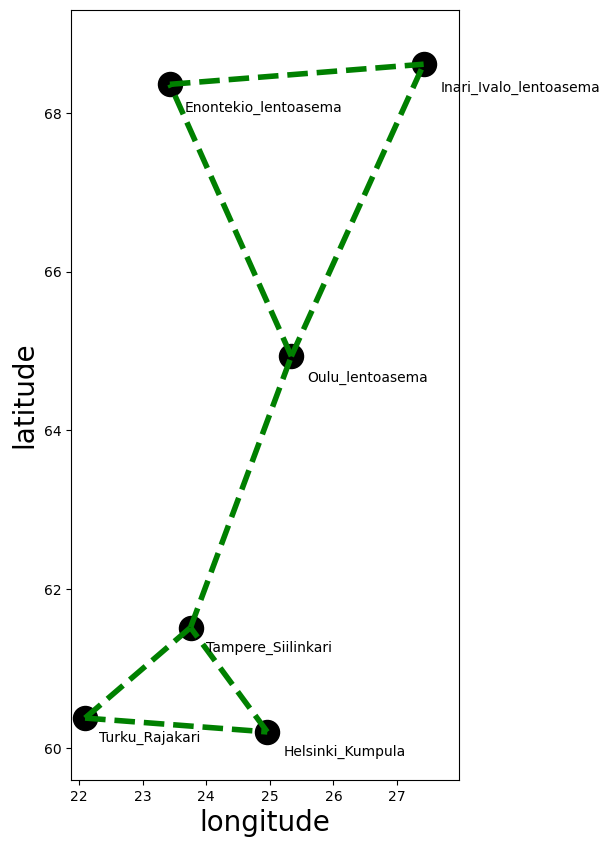

In [6]:
# create a plot of FMI stations. 
# - draw dashed lines between FMI stations if they are connected by an edge in the empirical graph G_FMI 
# - annotate each dot (representing a FMI station) by the station name

PlotFMIStations(G_FMI,"name") 

In [7]:

### STUDENT TASK ###

# use above function FedSGD with lrate=0.001, regparam=3 and maxiter=1000 
# to compute, for each node in G_FMI, the attribute "w" that stores the weights 
# of a linear hypothesis map. 


### STUDENT TASK ###

# use function PlotFMIStations to generated a scatter plot of FMI stations. annotate 
# each node with the weights learnt by FedSGD. 
